# 
Home Prices<br>
This note book aims at identifying home price trends in Denver market.<br>
We will begin by importing the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

Now that we have the necessary libraries lets pull in our data sets.  This data comes from the website below.<br>
https://www.zillow.com/research/data/

In [2]:
raw_listing = pd.read_csv('MonthlyListings_NSA_AllHomes_Metro.csv')
raw_price = pd.read_csv('Metro_Zhvi_SingleFamilyResidence.csv')

Now that the data is available we can take a cursory glance at the listing information.

In [3]:
raw_listing.head()

,SizeRank,RegionID,RegionName,RegionType,StateName,2013-01,2013-02,2013-03,2013-04,2013-05,...,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03
0,0,102001,United States,Country,NaN,1838233.0,1809181.0,1882505.0,1970115.0,2110294.0,...,1632324,1745156,1624517,1599609,1629856,1469678,1307037,1341455,1268877.0,1302142
1,1,394913,"New York, NY",Msa,NY,108807.0,107360.0,113532.0,119674.0,126111.0,...,95712,97985,89904,90573,91817,81804,71864,73496,73065.0,77897
2,2,753899,"Los Angeles-Long Beach-Anaheim, CA",Msa,CA,27254.0,29025.0,25735.0,26477.0,28613.0,...,28155,31577,28559,27841,27022,23825,19360,20335,19821.0,19420
3,3,394463,"Chicago, IL",Msa,IL,49270.0,49402.0,50693.0,53117.0,56741.0,...,49431,54409,51441,51099,51432,44577,38402,39168,39179.0,40050
4,4,394514,"Dallas-Fort Worth, TX",Msa,TX,31597.0,32320.0,33394.0,34833.0,37452.0,...,36296,39910,36371,34876,35052,31792,27835,28367,27614.0,28571


In [4]:
raw_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817 entries, 0 to 816
Data columns (total 92 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SizeRank    817 non-null    int64  
 1   RegionID    817 non-null    int64  
 2   RegionName  817 non-null    object 
 3   RegionType  817 non-null    object 
 4   StateName   816 non-null    object 
 5   2013-01     787 non-null    float64
 6   2013-02     787 non-null    float64
 7   2013-03     787 non-null    float64
 8   2013-04     787 non-null    float64
 9   2013-05     788 non-null    float64
 10  2013-06     788 non-null    float64
 11  2013-07     788 non-null    float64
 12  2013-08     789 non-null    float64
 13  2013-09     789 non-null    float64
 14  2013-10     789 non-null    float64
 15  2013-11     789 non-null    float64
 16  2013-12     789 non-null    float64
 17  2014-01     789 non-null    float64
 18  2014-02     789 non-null    float64
 19  2014-03     791 non-null    f

Between looking at the data types and the first five rows we can see that this table holds the number of homes on the market for metro areas through out the country.  We can also see that the data is presented by month.  Lets move on to sorting only for the Denver metro area.

In [5]:
listings = raw_listing[raw_listing.RegionName.str.contains('Den')]
listings

,SizeRank,RegionID,RegionName,RegionType,StateName,2013-01,2013-02,2013-03,2013-04,2013-05,...,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03
21,21,394530,"Denver, CO",Msa,CO,11476.0,11261.0,11669.0,12347.0,14432.0,...,10979,12954,11690,11481,11582,9225,7296,7139,5949.0,6932


Now that we are only looking at the Denver metro area lets pivot the information to display the month and year as the new index column. 

In [6]:
listings = listings.drop(['SizeRank', 'RegionID', 'RegionName', 'RegionType', 'StateName'], axis=1)
listings = listings.rename(index={21: 'Listings'})
listings = listings.transpose()
listings.index.names = ['date']

Next lets check for any missing values.

In [7]:
listings.isnull().sum()

Listings    0
dtype: int64

With the listing data clean and useable lets move forward to the price data.  For starters we will consider what the raw data holds.

In [8]:
list(raw_price.groupby('StateName'))

[('AK',
       RegionID  SizeRank     RegionName RegionType StateName  1996-01-31  \
  133    394327       133  Anchorage, AK        Msa        AK    135245.0   
  387    394580       387  Fairbanks, AK        Msa        AK         NaN   
  797    394730       810     Juneau, AK        Msa        AK         NaN   
  914    394743       933  Ketchikan, AK        Msa        AK         NaN   
  
       1996-02-29  1996-03-31  1996-04-30  1996-05-31  ...  2019-07-31  \
  133    135771.0    136235.0    137199.0    137903.0  ...    341792.0   
  387         NaN         NaN         NaN         NaN  ...    252482.0   
  797         NaN         NaN         NaN         NaN  ...    420905.0   
  914         NaN         NaN         NaN         NaN  ...    326816.0   
  
       2019-08-31  2019-09-30  2019-10-31  2019-11-30  2019-12-31  2020-01-31  \
  133    343510.0    345354.0    347029.0    348590.0    349400.0    349456.0   
  387    253362.0    252658.0    251082.0    249235.0    248671.0    

This dataframe looks similar to the original listings set that was just cleaned.  I will start by repeating a few of those steps to get just the Denver data.

In [9]:
price = raw_price[raw_price.RegionName.str.contains('Denver')]
price = price.drop(['SizeRank', 'RegionID', 'RegionName', 'RegionType', 'StateName'], axis=1)
price = price.rename(index={21: 'Average Price'})
price

,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,...,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30
Average Price,150089.0,150641.0,151062.0,151862.0,152481.0,153091.0,153702.0,154307.0,154909.0,155479.0,...,450876.0,451838.0,452605.0,453437.0,454141.0,455660.0,457718.0,459547.0,461364.0,463029.0


Next we can rename the column headers to match those of the listings. To accomplish this we are going to create a dictionary and then

In [10]:
string = []
for c_name in price.columns:
        string.append(c_name[:7])
price = price.transpose()
price['date'] = string
price.set_index('date')

,Average Price
date,
1996-01,150089.0
1996-02,150641.0
1996-03,151062.0
1996-04,151862.0
1996-05,152481.0
...,...
2019-12,455660.0
2020-01,457718.0
2020-02,459547.0


In [11]:
clean_data = pd.merge(price, listings, on='date')
clean_data = clean_data.set_index('date')
clean_data

,Average Price,Listings
date,,
2013-01,262821.0,11476.0
2013-02,265265.0,11261.0
2013-03,268090.0,11669.0
2013-04,270401.0,12347.0
2013-05,272412.0,14432.0
...,...,...
2019-11,454141.0,9225.0
2019-12,455660.0,7296.0
2020-01,457718.0,7139.0


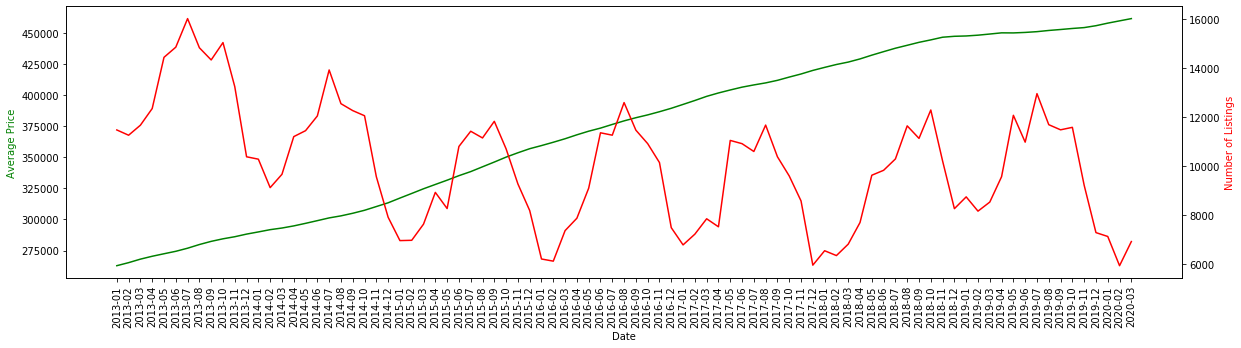

In [12]:
plt.rcParams['figure.figsize'] = [20, 5]
fig,ax = plt.subplots()
ax.plot(clean_data['Average Price'], color="green")
ax.set_xlabel("Date")
plt.xticks(rotation=90)
ax.set_ylabel("Average Price", color="green")
ax2=ax.twinx()
ax2.plot(clean_data['Listings'], color="red")
ax2.set_ylabel("Number of Listings", color="red")
plt.xticks(rotation=90)
plt.show()

Let’s zoom in and see if we can see any more detail.  

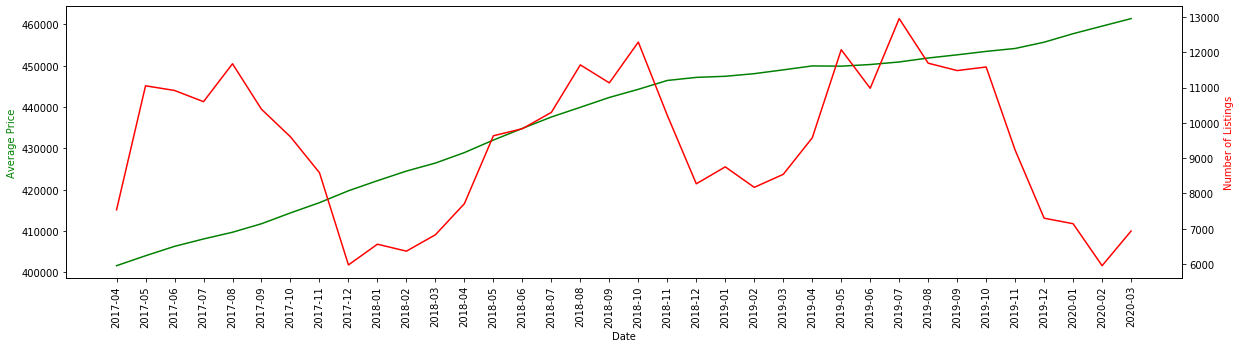

In [13]:
zplot = clean_data.tail(36)
plt.rcParams['figure.figsize'] = [20, 5]
fig,ax = plt.subplots()
ax.plot(zplot['Average Price'], color="green")
ax.set_xlabel("Date")
plt.xticks(rotation=90)
ax.set_ylabel("Average Price", color="green")
ax2=ax.twinx()
ax2.plot(zplot['Listings'], color="red")
ax2.set_ylabel("Number of Listings", color="red")
plt.xticks(rotation=90)
plt.show()

Now let’s add a column showing only the month number and see if there is a visible pattern between the month and number of listings.

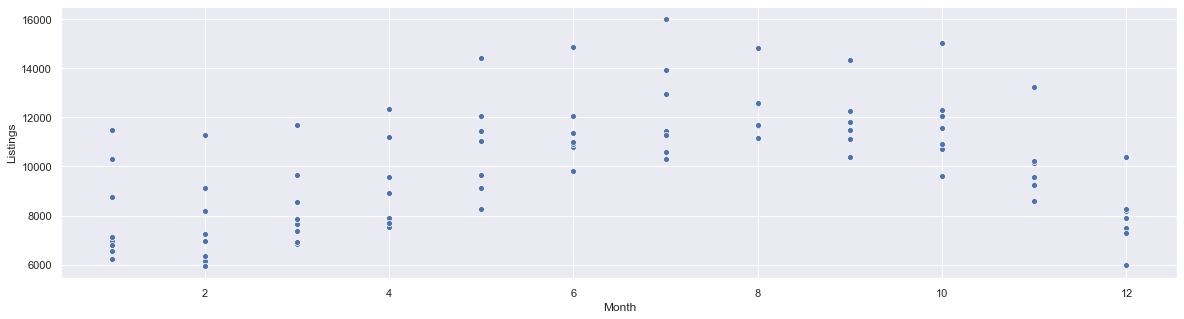

In [14]:
clean_data['Month'] = clean_data.index.values
clean_data['M1'] = clean_data['Month'].str[-2:]
clean_data = clean_data.drop(['Month'], axis=1)
clean_data = clean_data.rename(columns={'M1':'Month'})
clean_data['Month'] = clean_data['Month'].astype(int)
sns.set(style="darkgrid")
sns.scatterplot(x='Month', y='Listings', data=clean_data)

Based on the above chart it seems that there is a clear trend to have higher number of listings in the summer months than the winter.<br>
Now let’s test the hypothesis that the lower the number of listings will result in a higher price.

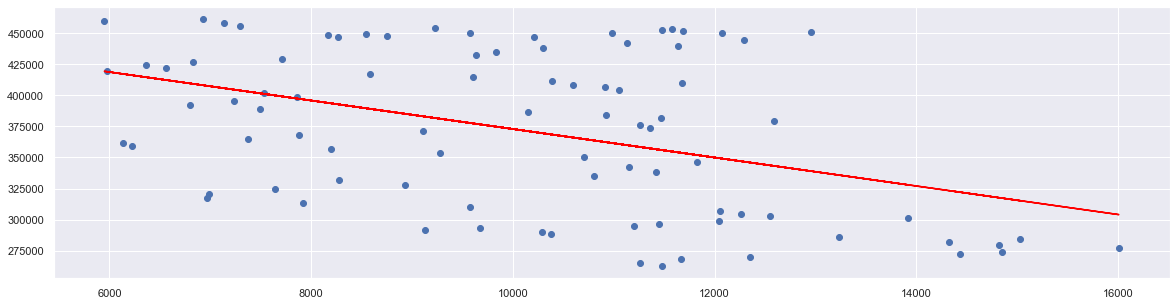

In [16]:
y = clean_data['Average Price']
x = clean_data.Listings.values.reshape((-1, 1))
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
y_pred = model.predict(x)
plt.scatter(x, y)
plt.plot(x, y_pred, color='red')
plt.show()

Based on that chart I would say that the linear model does follow the overall trend but it looks like we are missing a few variables from this simplistic analysis.  Let’s check the R-squared values to be positive.

In [17]:
r_sq

0.1811843340714554

Based on that value we have a fairly low fit for our model.  If I were to complete this activity again, I would add in population movements, unemployment, and new home building permits.  All of these could potentially improve our model and help to predict a more accurate pricing model.